# Tweet Classification with Naive Bayes

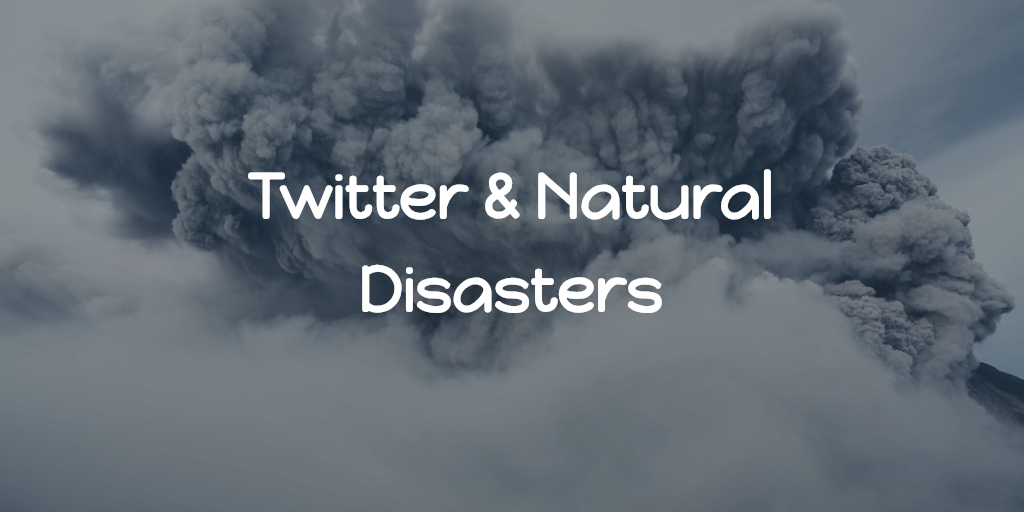

# Import packages

In [ ]:
# Basic packages
import re
import string
import re
import numpy as np
import pandas as pd
from itertools import chain

# Data Vizualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn packages
from sklearn.model_selection import train_test_split

# NLP packages
import nltk
from nltk.tokenize import word_tokenize
import emoji
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

## Tips on data cleaning
 
* Consider the words of your corpus as case insensitive. ex "THE"=="the"=="The"
* Represent all interrupting punctuation marks as a single special word of the vocabulary.
* Ignore non interrupting punctuation marks such a quotes.
* Collapse multiple sign marks into a single mark. Ex- "???" -> "?" 
* If numbers do not carry a special meaning in your use case you can drop them.
* If numbers are meaingful for your use case you can keep them, however if you have a lot of unique numbers in your corpus it's safe to replace them with a single token.
* It is usually safe to drop the special characters like $\alpha$, $\mathscr{L}$.
* Special words Emojis or hashtags can be considered as a separate word.

In [ ]:
# Example
nltk.download('punkt') # Pre trained tokenizer for english.
corpus = 'Who ❤️ "word embeddings" in 2020? I do!!!'
data = re.sub(r'[,!?;-]+', '.', corpus)
print(data)
data = nltk.word_tokenize(data)
data = [char for char in data if char.isalpha() or char == '.' or emoji.get_emoji_regexp().search(char)]
print(data)

In [ ]:
def process_tweet(tweet):
    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet
    '''
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
            word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)
    return tweets_clean

# Import Data

In [ ]:
PATH = '../input/nlp-getting-started/'
train = pd.read_csv(f'{PATH}train.csv')
test = pd.read_csv(f'{PATH}test.csv')
sample_submission = pd.read_csv(f'{PATH}sample_submission.csv')

# EDA

In [ ]:
train.head()

Keyword and location features have null values in the train as well as the test data sets.

In [ ]:
train.info() , test.info()

There is no significant class imbalance in this problem and can be considered as a balanced problem.

In [ ]:
train['target'].value_counts(normalize=True)

### 1. Let's explore the keyword feature.

There are 221 unique values that the keyword feature takes.

In [ ]:
train['keyword'].nunique()

Let's look at top 10 keywords and their frequencies.

In [ ]:
train.groupby(['keyword'])['keyword'].count()[:10]

# Data Preprocessing

In [ ]:
# Clean the data.
train['text_clean'] = train['text'].apply(process_tweet)
test['text_clean'] = test['text'].apply(process_tweet)

In [ ]:
train.head()

Split the data into train and validation sets.

In [ ]:
X = train.loc[:, ['text_clean']]
y = np.ravel(train.loc[:,'target'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,random_state=42, shuffle=True, stratify=y)

In [ ]:
type(X)

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [ ]:
X_train.head()

# Develop Naive Bayes algorithm from scratch

\begin{equation*}
P(A | B)   =  \frac {P(B | A) *  P(A)}{P(B)}
\end{equation*}

Prior probability: $P(A)$ is the probability of an event before new data is collected.
<br>
Posterior probability: $P(A\mid B)$ is the revised or updated probability of an event occurring after taking into consideration new information
<br>
Likelihood: $P(B\mid A)$ Referred to as likelihood.
<br>
Evidence: $P(B)$ Referred to as evidence.

### Understanding Naive Bayes Algorithm

This algorithm is all about conditional probabilities. The basic idea is to calculate the probability of observing different words given that they occur in a disaster or non-disaster tweet. For example, what is the probability of observing the word "ablaze", in a disaster and non-disaster tweet. $P(ablaze\mid disaster)$ and $P(ablaze\mid non-disaster)$. Similarly we can calculate these probabilities of all the words in the corpus and then use the Bayes Rule to calculate the inverse probability $P(disaster\mid ablaze)$.

Let's understand how this can be used to classify a tweet as disaster or non-disaster.  

Create a list of all the words in the corpus. This is also know as the vocabulary. The snippet below indicates how to do this.

In [ ]:
# Get the distinct tokens to form a vocabulary.
def get_vocabulary(X_train):
    vocab = X_train['text_clean'].tolist() # Convert series to list of tokens.
    vocab = list(chain.from_iterable(vocab)) # Unest the list.
    vocab = set(vocab) # Get the distinct tokens from list.
    vocab = list(set(vocab)) # Convert the set to list
    return vocab

Next step is to calculate the probability of getting a disaster and non-disaster tweet $P(disaster)$ and $P(non-disaster)$. This is very simple since we have the labelled training data which we can use to get this. Using this we can define the prior which nothig but the ratio of disaster to non-disaster tweets in our training data. $$\frac{P(disaster)} {P(non-disaster)}$$ 

In [ ]:
# Prior and Logprior.
def get_log_prior(y_train):
    T = len(y_train) # Total number of tweets
    D = np.sum(y_train) # No of tweets about disasters.
    ND = T - D # No of tweets not about disasters.

    P_D = D / T # Probability of getting a tweet about disaster in the corpus.
    P_ND = 1 - P_D # Probability of getting a non-disaster tweet in the corpus.
    log_prior = np.log(P_D / P_ND)
    return log_prior

In [ ]:
# Create a dictionary which would store for each word in the vocabulary, it's label and the associated frequency with that label.
def frequency_dict(X_train, y_train):
    d = dict()
    for tweet, label in zip (X_train['text_clean'], y_train):
        for word in tweet:
            pair = (word, label)
            if pair in d:
                d[pair] += 1
            else: 
                d[pair] = 1
    return d           

In [ ]:
# Compute the likelihood of a tweet being disaster or non-disaster.
def compute_likelihood(freqs_dict, vocab):
    # Get the sum of frequencies of occurrence of words in case of disaster and non-disaster.
    sum_words_pos = 0 # Sum of the Frequency of a token in tweets that are about Disaster.
    sum_words_neg = 0 # Sum of the Frequency of a token in tweets that are Not Disaster related.
    loglikelihood = dict()
    
    for pair, cnt in freqs_dict.items():
        if pair[1] == 1:
            sum_words_pos += cnt
        else:
            sum_words_neg += cnt
            
    for token in vocab:
        pos_cnt = freqs_dict.get((token, 1), 0)
        neg_cnt = freqs_dict.get((token, 0), 0)
        p_pos = (pos_cnt + 1) / (sum_words_pos + len(vocab)) # Probability that the tweet is about disaster given the word.
        p_neg = (neg_cnt + 1) / (sum_words_neg + len(vocab)) # Probability that the tweet is not about disaster given the word.
        ratio = np.log(p_pos/p_neg) # Log likelihood for the word.
        loglikelihood[token] = ratio
    return loglikelihood  

In [ ]:
def train_naive_bayes(X_train, y_train):
    logprior = get_log_prior(y_train)
    vocab = get_vocabulary(X_train)
    freqs_dict = frequency_dict(X_train, y_train)
    loglikelihood = compute_likelihood(freqs_dict, vocab)
    return logprior, loglikelihood

In [ ]:
logprior, loglikelihood = train_naive_bayes(X_train, y_train)

In [ ]:
def predict_naive_bayes(X, logprior, loglikelihood):
    y_pred = list()
    
    for row in X.itertuples():
        prediction = logprior    
        tweet = row.text_clean
    
        for token in tweet:
            prediction += loglikelihood.get(token, 0)
            
        temp = 1 if prediction > 0 else 0
        y_pred.append(temp)
    return y_pred

# Check accuracy on validation set

In [ ]:
y_pred = predict_naive_bayes(X_val,  logprior, loglikelihood)

In [ ]:
count = 0
for actual, prediction in zip(y_val, y_pred):
    if actual == prediction:
        count += 1
print(count / len(y_val))    

# Prediction on Test data.

In [ ]:
y_test = predict_naive_bayes(test, logprior, loglikelihood)
df_out = pd.DataFrame({
    'id': test['id'],
    'target': y_test 
})
df_out.to_csv('df_out1.csv',mode = 'w', index=False)